In [1]:
import cv2
import imutils
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import ipynb
from ipynb.fs.defs.sudoku_solver import sudoku


class ocr_solver(sudoku):
    
    def __init__(self, image):
        self.image = str(image)
        self.solved_cells = []
        self.grid = np.zeros((9, 9))
        self.cells = []
        self.row = []
        self.digit_model = keras.models.load_model("model")
        super().__init__()
    
    def isolate_cells(self):

        # Load image, grayscale, and adaptive threshold
        image = cv2.imread(self.image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

        kernel = np.ones((5,5),np.uint8)
        dilation = cv2.dilate(thresh,kernel,iterations = 1)

        image_size = image.shape[0]*image.shape[1]

        # Fill out the cells (area less than 1000) to filter numbers to isolate only boxes
        cnts = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            area = cv2.contourArea(c)
            if area < (image_size/81 + 500):
                draw = cv2.drawContours(dilation, [c], -1, (0,0,0), -1)


        # Isolate the x-y coordinates of each box
        cnts = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts[0]:
            if cv2.contourArea(c) < (image_size/81 + 500):
                rect = cv2.boundingRect(c)
                self.cells.append(rect)

        self.cells = self.cells[::-1]

        index = 0
        for i in range(9):
            sorted_X = self.cells[index:index+9]
            sorted_X.sort()
            self.row.append(sorted_X)
            index += 9

        return
    
    def solved_image(self):
        self.isolate_cells()
        og = cv2.imread(self.image)
        image = cv2.imread(self.image)
        empty_grid = self.image_to_grid()
        super().set_grid(empty_grid)
        super().solve()
        sol = super().get_solved()
        sol = np.asarray(sol)
        sol
        for cell in self.solved_cells:
            num = int(sol[cell[0]][cell[1]])
            org = (cell[2]+15, cell[3]+35)
            image_shown = cv2.putText(image, str(num), org, cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255), 2, cv2.LINE_AA, False)
        plt.imshow(og)
        plt.show()
        plt.imshow(image_shown)
        plt.show()
        
    def image_to_grid(self):
        
        for i in range(9):
            for j in range(9):
                x = self.row[i][j][0]
                y = self.row[i][j][1]
                w = self.row[i][j][2]
                h = self.row[i][j][3]
                
                image = cv2.imread(self.image)
                cropped = image[y+5: y+h-5, x+5: x+w-5]
                resized = cv2.resize(cropped, (28,28), interpolation = cv2.INTER_LINEAR)
                resized_count = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
                
                resized = 255 - resized
                resized_count = 255 - resized_count
    
                if np.count_nonzero(resized_count)/(resized_count.shape[0]*resized_count.shape[1]) < 0.2:
                    self.grid[i][j]=0
                    self.solved_cells.append([i, j, x, y, h])
                else:
    
                    val = self.image_to_cell(resized)
                    self.grid[i][j]=val
    
        return self.grid
    
    def image_to_cell(self, img):
    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = tf.expand_dims(img, axis=-1)
        img = tf.expand_dims(img, axis=0)
        num = self.digit_model(img)
        return np.argmax(num, axis=1)[0]
    
    def digit_to_image(i, j):
        i = i - 1
        j = j - 1

        x = row[i][j][0]
        y = row[i][j][1]
        w = row[i][j][2]
        h = row[i][j][3]

        cropped = image[y+5: y+h-5, x+5: x+w-5]
        resized = cv2.resize(cropped, (28,28), interpolation = cv2.INTER_LINEAR)
        purple = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        purple = 255 - purple
        plt.imshow(purple)
        plt.show()
        return purple
    
    def create_image_dataset(x,y,n):
        dataset = []
        num = n
        purple = digit_to_image(x,y)
        rot_left = imutils.rotate(purple, 15)
        rot_right = imutils.rotate(purple, -15)

        purple_d = purple.flatten()
        rot_left = rot_left.flatten()
        rot_right = rot_right.flatten()

        purple_d = np.insert(purple_d, 0, num, axis=0)
        rot_left = np.insert(rot_left, 0, num, axis=0)
        rot_right = np.insert(rot_right, 0, num, axis=0)

        dataset.append(purple_d)
        dataset.append(rot_left)
        dataset.append(rot_right)

        dataset = pd.DataFrame(dataset)
        dataset.rename(columns={ dataset.columns[0]: "label" }, inplace=True)
        return data

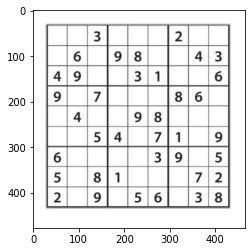

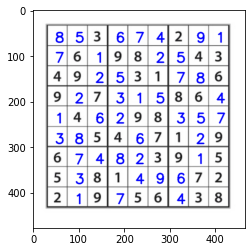

In [2]:
ocr = ocr_solver('sudoku.png')
ocr.solved_image()

In [3]:
#dataset.to_csv("sudoku_digits.csv", mode='a', header=False)

In [4]:
#data.to_csv("sudoku_digits.csv")